In [1]:
def reduce_mem_usage_colwise(col):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_type = col.dtypes
    if col_type in numerics:
        c_min = col.min()
        c_max = col.max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col = col.astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col = col.astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col = col.astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col = col.astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                col = col.astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col = col.astype(np.float32)
            else:
                col = col.astype(np.float64)       
    return col

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score

import xgboost as xgb

import multiprocessing as mp
from functools import partial
import gc
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%%time
DATA_PATH = 'Data/'
OUTPUT_PATH = 'Output/'

train = pd.read_csv(DATA_PATH + 'train_data.csv')
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_sub = pd.read_csv(DATA_PATH + 'Sample Submission.csv')

CPU times: user 16.7 s, sys: 1.92 s, total: 18.6 s
Wall time: 18.6 s


In [4]:
train = pd.merge(train, train_labels, on = 'patient_id', how='left')
df = pd.concat([train, test])
df = df.drop_duplicates()

comp_train = train_labels.copy()
comp_test = sample_sub.copy()

In [5]:
# Consider the data only for the last 6 months
df = df[df['event_time'] < 180]

In [6]:
df['made_payment'] = pd.qcut(df['patient_payment'], 25000, duplicates='drop', labels=False).astype('str')

In [7]:
%%time
for c in ['event_name', 'plan_type', 'specialty', 'made_payment']:
    temp = df.groupby(['patient_id', c]).size().unstack().reset_index()
    temp.columns = [col + '_size_' + c if col != 'patient_id' else 'patient_id' for col in temp.columns]
    comp_train = pd.merge(comp_train, temp, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, temp, on = 'patient_id', how='left')

CPU times: user 5.33 s, sys: 780 ms, total: 6.11 s
Wall time: 6.11 s


In [8]:
%%time
for c in ['event_name', 'plan_type', 'specialty', 'made_payment']:
    temp = df.groupby(c).apply(lambda x: x.groupby('patient_id')['event_time'].min()).unstack().T.reset_index()
    temp.columns = ['recency_' + col + '_' + c if col != 'patient_id' else 'patient_id' for col in temp.columns]
    comp_train = pd.merge(comp_train, temp, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, temp, on = 'patient_id', how='left')

CPU times: user 12.1 s, sys: 1.34 s, total: 13.4 s
Wall time: 13.4 s


In [9]:
%%time
for c in ['event_name', 'plan_type', 'specialty', 'made_payment']:
    temp = df.groupby(c).apply(lambda x: x.groupby('patient_id')['event_time'].nunique()).unstack().T.reset_index()
    temp.columns = ['unique_event_time_' + col + '_' + c if col != 'patient_id' else 'patient_id' for col in temp.columns]
    comp_train = pd.merge(comp_train, temp, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, temp, on = 'patient_id', how='left')

CPU times: user 15.6 s, sys: 2.32 s, total: 17.9 s
Wall time: 17.9 s


In [10]:
%%time
for c in ['event_name', 'plan_type', 'specialty']:
    payment = df.groupby(c).apply(lambda x: x.groupby('patient_id')['patient_payment'].sum()).unstack().T.reset_index()
    payment.columns = [col + '_total_payment_' + c if col != 'patient_id' else 'patient_id' for col in payment.columns]
    comp_train = pd.merge(comp_train, payment, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, payment, on = 'patient_id', how='left')

CPU times: user 7.17 s, sys: 1.21 s, total: 8.38 s
Wall time: 8.38 s


In [11]:
%%time
for c in ['event_name', 'plan_type', 'specialty']:
    payment = df.groupby(c).apply(lambda x: x.groupby('patient_id')['patient_payment'].mean()).unstack().T.reset_index()
    payment.columns = [col + '_mean_payment_' + c if col != 'patient_id' else 'patient_id' for col in payment.columns]
    comp_train = pd.merge(comp_train, payment, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, payment, on = 'patient_id', how='left')

CPU times: user 7.23 s, sys: 1.2 s, total: 8.43 s
Wall time: 8.42 s


In [12]:
%%time
for c in ['event_name', 'plan_type', 'specialty']:
    payment = df.groupby(c).apply(lambda x: x.groupby('patient_id')['patient_payment'].max()).unstack().T.reset_index()
    payment.columns = [col + '_max_payment_' + c if col != 'patient_id' else 'patient_id' for col in payment.columns]
    comp_train = pd.merge(comp_train, payment, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, payment, on = 'patient_id', how='left')

CPU times: user 7.38 s, sys: 1.33 s, total: 8.72 s
Wall time: 8.71 s


In [13]:
comp_train = comp_train.apply(lambda x: reduce_mem_usage_colwise(x))
comp_test = comp_test.apply(lambda x: reduce_mem_usage_colwise(x))

In [14]:
del train, test, df, temp, payment
gc.collect()

0

In [15]:
train, test = comp_train, comp_test
ID_COL, TARGET_COL = 'patient_id', 'outcome_flag'
target = train[TARGET_COL]
features = [c for c in train if c not in [ID_COL, TARGET_COL]]
features = train[features].isnull().sum().sort_values(ascending=False)[250:].index.tolist()
len(features)

10394

In [16]:
params = {
    'learning_rate': 0.01,
    'max_depth': 4,
    'colsample_bytree':.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'silent': 1,
    "lambda": 5,
    "lambda_l2":5,
    'scale_pos_weight': 1,
    'grow_policy': 'lossguide',
    'max_leaves': 50,
    'tree_method': 'exact',
    'alpha': 0.5,
    'colsample_bynode': 0.3
}
gc.collect()

0

In [17]:
max_iter = 10
folds = StratifiedKFold(n_splits=10, random_state=1991)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    X_trn, y_trn = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_trn = xgb.DMatrix(X_trn, label=y_trn)
    X_val = xgb.DMatrix(X_val, label=y_val)
    X_test = xgb.DMatrix(test[features])
    clf = xgb.train(params, X_trn, 50000, [(X_trn,'train'),(X_val,'val')], verbose_eval = 400, early_stopping_rounds=800)
    gc.collect()
    oof[val_idx] = clf.predict(X_val)
    
    fold_importance_df = pd.DataFrame({"importance": clf.get_fscore(), "fold": fold_ + 1}).reset_index().rename({'index': 'feature'}, axis=1)
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    current_pred = clf.predict(X_test)
    predictions += current_pred / min(folds.n_splits, max_iter)


print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold n°0
[0]	train-auc:0.686532	val-auc:0.679817
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 800 rounds.
[400]	train-auc:0.853191	val-auc:0.837027
[800]	train-auc:0.88649	val-auc:0.857536
[1200]	train-auc:0.905444	val-auc:0.864859
[1600]	train-auc:0.918911	val-auc:0.868284
[2000]	train-auc:0.929382	val-auc:0.869755
[2400]	train-auc:0.937507	val-auc:0.870772
[2800]	train-auc:0.944407	val-auc:0.871664
[3200]	train-auc:0.950201	val-auc:0.872386
[3600]	train-auc:0.955139	val-auc:0.872994
[4000]	train-auc:0.959533	val-auc:0.873171
[4400]	train-auc:0.963349	val-auc:0.873616
[4800]	train-auc:0.96661	val-auc:0.873252
[5200]	train-auc:0.969515	val-auc:0.87314
Stopping. Best iteration:
[4412]	train-auc:0.963447	val-auc:0.873722

fold n°1
[0]	train-auc:0.683774	val-auc:0.683527
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 800 rounds

In [18]:
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.84746 


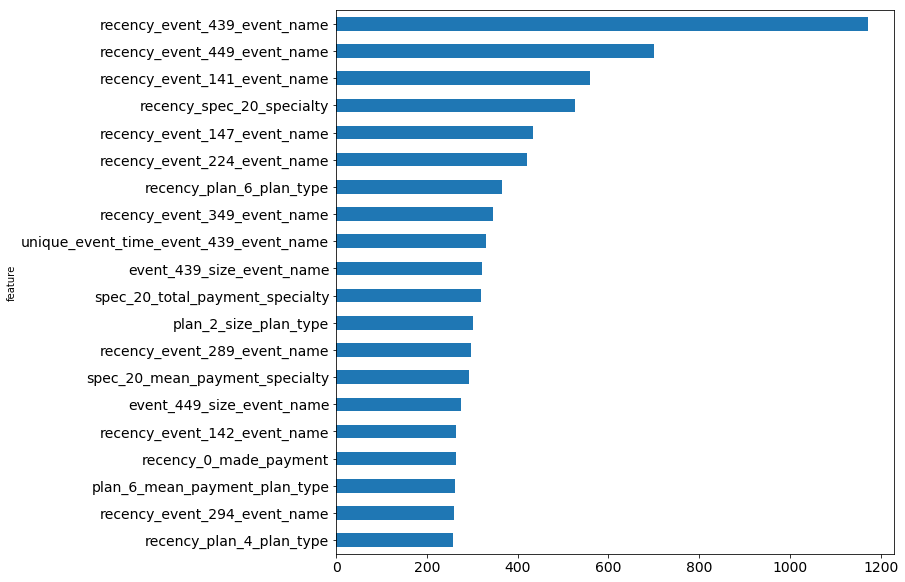

In [19]:
fi = feature_importance_df.groupby('feature')['importance'].mean().sort_values()
plt.figure(figsize=(10,10))
fi[-20:].plot.barh(fontsize=14)

In [20]:
print(f"Total no. of useful features are: {(fi != 0).sum()}")

Total no. of useful features are: 2690


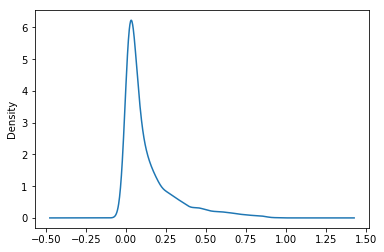

In [21]:
_ = pd.Series(predictions).plot(kind='density')

In [22]:
oof_df = pd.DataFrame()
oof_df['patient_id'] = comp_train['patient_id']
oof_df[TARGET_COL] = oof
oof_df.to_csv(OUTPUT_PATH + 'oofs_xgb_2.csv', index=False)

In [23]:
sub_df = pd.DataFrame()
sub_df[ID_COL] = comp_test[ID_COL]
sub_df[TARGET_COL] = predictions
sub_df[[TARGET_COL]].to_excel(OUTPUT_PATH + 'preds_xgb_2.xlsx', index=False)
sub_df.head(10)

,patient_id,outcome_flag
0,patient_2,0.083744
1,patient_3,0.115366
2,patient_5,0.619801
3,patient_8,0.013233
4,patient_14,0.312857
5,patient_15,0.044436
6,patient_16,0.015750
7,patient_33,0.154302
8,patient_38,0.049512
9,patient_41,0.144371


In [24]:
print("DONE-------------- !!!")

DONE-------------- !!!
